# Mean/Covariance of a data set and effect of a linear transformation

We are going to investigate how the mean and (co)variance of a dataset changes
when we apply affine transformation to the dataset.

## Learning objectives
1. Get Familiar with basic programming using Python and Numpy/Scipy.
2. Learn to appreciate implementing
   functions to compute statistics of dataset in vectorized way.
3. Understand the effects of affine transformations on a dataset.
4. Understand the importance of testing in programming for machine learning.

First, let's import the packages that we will use for the week

In [1]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
matplotlib.style.use('fivethirtyeight')
from sklearn.datasets import fetch_lfw_people, fetch_olivetti_faces
import time
import timeit

In [2]:
%matplotlib inline
from ipywidgets import interact

Next, we are going to retrieve Olivetti faces dataset.

When working with some datasets, before digging into further analysis, it is almost always
useful to do a few things to understand our dataset. First of all, answer the following
set of questions:

1. What is the size of our dataset?
2. What is the dimensionality of our data?

The dataset we have are usually stored as 2D matrices, then it would be really important
to know which dimension represents the dimension of the dataset, and which represents
the data points in the dataset. 

For this assignment, our data is organized as
__(D,N)__, where D is the dimensionality of the samples and N is the number of samples.

In [3]:
image_shape = (64, 64)
# Load faces data
dataset = fetch_olivetti_faces('./')
faces = dataset.data.T

print('Shape of the faces dataset: {}'.format(faces.shape))
print('{} data points'.format(faces.shape[1]))

Shape of the faces dataset: (4096, 400)
400 data points


When our dataset are images, it's a really good idea to see what they look like.

One very
convenient tool in Jupyter is the `interact` widget, which we use to visualize the images (faces). For more information on how to use interact, have a look at the documentation [here](http://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html).

In [4]:
def show_face(face):
    plt.figure()
    plt.imshow(face.reshape((64, 64)), cmap='gray')
    plt.show()

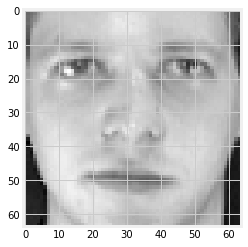

In [5]:
@interact(n=(0, faces.shape[1]-1))
def display_faces(n=0):
    plt.figure()
    plt.imshow(faces[:,n].reshape((64, 64)), cmap='gray')
    plt.show()

## 1. Mean and Covariance of a Dataset

We will need to implement functions in the cell below which compute the mean and covariance of a dataset.

We will implement both mean and covariance in two different ways. First, we will implement them using Python's for loops to iterate over the entire dataset. Later, we will learn to take advantage of Numpy and use its library routines. In the end, we will compare the speed differences between the different approaches.

In [6]:
def mean_naive(X):
    "Compute the mean for a dataset X by iterating over the data points"
    # X is of size (D,N) where D is the dimensionality and N the number of data points
    D, N = X.shape
    mean = np.zeros((D,1))
    ### iterate over the dataset and compute the mean vector
    for n in range(N):
        mean[:, 0] = mean[:, 0] + X[:, n]
    mean = mean / N
    ###
    return mean

def cov_naive(X):
    """Compute the covariance for a dataset of size (D,N) 
    where D is the dimension and N is the number of data points"""
    D, N = X.shape
    ### compute the covariance matrix by iterating over the dataset
    covariance = np.zeros((D, D))
    for d in range(D):
        for n in range(N):
            covariance[d,:] = covariance[d,:] + (X[d,n]-mean_naive(X)[d]) * (X[d,n]-mean_naive(X)[d]).T
    covariance = covariance / N
    ###
    return covariance


def mean(X):
    "Compute the mean for a dataset of size (D,N) where D is the dimension and N is the number of data points"
    # given a dataset of size (D, N), the mean should be an array of size (D,1)
    # we can use np.mean, but need to pay close attention to the shape of the mean vector we are returning
    D, N = X.shape
    ### compute a (D,1) array `mean` for the mean of dataset
    mean = np.zeros((D,1))
    mean[:,0] = (mean[:,0] + np.sum(X, axis = 1)) / N
    #mean = np.mean(X, axis = 1).reshape(D,1)
    ###
    return mean

def cov(X):
    "Compute the covariance for a dataset"
    # X is of size (D,N)
    # It is possible to vectorize our code for computing the covariance with matrix multiplications,
    # i.e., we do not need to explicitly
    # iterate over the entire dataset as looping in Python tends to be slow
    # We can give a vectorized implementation without using np.cov, but if we choose to use np.cov,
    # we need to be sure to pass in bias=True.
    D, N = X.shape
    ### compute the covariance matrix
    covariance_matrix = np.zeros((D, D))
    covariance_matrix = np.matmul(X - mean(X), (X - mean(X)).T) / N
    ###
    return covariance_matrix

Now, let's see whether our implementations are consistent

In [7]:
# Let's first test the functions on some hand-crafted dataset.

X_test = np.arange(6).reshape(2,3)
expected_test_mean = np.array([1., 4.]).reshape(-1, 1)
expected_test_cov = np.array([[2/3., 2/3.], [2/3.,2/3.]])
print('X:\n', X_test)
print('Expected mean:\n', expected_test_mean)
print('Expected covariance:\n', expected_test_cov)

np.testing.assert_almost_equal(mean(X_test), expected_test_mean)
np.testing.assert_almost_equal(mean_naive(X_test), expected_test_mean)

np.testing.assert_almost_equal(cov(X_test), expected_test_cov)
np.testing.assert_almost_equal(cov_naive(X_test), expected_test_cov)

X:
 [[0 1 2]
 [3 4 5]]
Expected mean:
 [[1.]
 [4.]]
Expected covariance:
 [[0.66666667 0.66666667]
 [0.66666667 0.66666667]]


We now test that both implementation should give identical results running on the faces dataset.

In [8]:
np.testing.assert_almost_equal(mean(faces), mean_naive(faces), decimal=6)
np.testing.assert_almost_equal(cov(faces), cov_naive(faces))

KeyboardInterrupt: 

With the `mean` function implemented, let's take a look at the _mean_ face of our dataset!

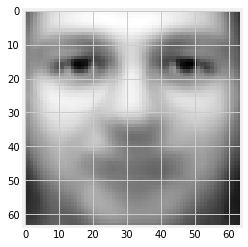

In [9]:
def mean_face(faces):
    return faces.mean(axis=1).reshape((64, 64))

plt.imshow(mean_face(faces), cmap='gray');

Loops in Python are slow, and most of the time we want to utilise the fast native code provided by Numpy without explicitly using
for loops. To put things into perspective, we can benchmark the two different implementation with the `%time` function
in the following way:

In [10]:
# We have some HUUUGE data matrix which we want to compute its mean
X = np.random.randn(20, 1000)
# Benchmarking time for computing mean
%time mean_naive(X)
%time mean(X)
pass

CPU times: user 6.01 ms, sys: 84 µs, total: 6.1 ms
Wall time: 6.44 ms
CPU times: user 350 µs, sys: 88 µs, total: 438 µs
Wall time: 427 µs


In [11]:
# Benchmarking time for computing covariance
%time cov_naive(X)
%time cov(X)
pass

KeyboardInterrupt: 

CPU times: user 3.62 ms, sys: 28.1 ms, total: 31.7 ms
Wall time: 109 ms


Using Numpy's functions should make the code much faster. Therefore, whenever we can use something that's implemented in Numpy, we need to be sure that we take advantage of that.

## 2. Affine Transformation of Datasets
We are also going to verify a few properties about the mean and
covariance of affine transformation of random variables.

Consider a data matrix $\boldsymbol X$ of size $(D, N)$. We would like to know
what is the covariance when we apply affine transformation $\boldsymbol A\boldsymbol x_i + \boldsymbol b$ for each datapoint $\boldsymbol x_i$ in $\boldsymbol X$, i.e.,
we would like to know what happens to the mean and covariance for the new dataset if we apply affine transformation.

We will need to implement the `affine_mean` and `affine_covariance` in the cell below.

In [12]:
def affine_mean(mean, A, b):
    """Compute the mean after affine transformation
    Args:
        x: ndarray, the mean vector
        A, b: affine transformation applied to x
    Returns:
        mean vector after affine transformation
    """
    ### compute the mean vector after affine transformation
    affine_m = np.zeros(mean.shape) # affine_m has shape (D, 1)
    affine_m = A @ mean + b
    ###
    return affine_m

def affine_covariance(S, A, b):
    """Compute the covariance matrix after affine transformation
    Args:
        S: ndarray, the covariance matrix
        A, b: affine transformation applied to each element in X        
    Returns:
        covariance matrix after the transformation
    """
    ### compute the covariance matrix after affine transformation
    affine_cov = np.zeros(S.shape) # affine_cov has shape (D, D)
    affine_cov = A @ S @ A.T
    ###
    return affine_cov

Once the two functions above are implemented, we can verify the correctness our implementation. Assuming that we have some $\boldsymbol A$ and $\boldsymbol b$.

In [13]:
random = np.random.RandomState(42)
A = random.randn(4,4)
b = random.randn(4,1)

Next we can generate some random matrix $\boldsymbol X$.

In [14]:
X = random.randn(4,100) # D = 4, N = 100

Assuming that for some dataset $\boldsymbol X$, the mean and covariance are $\boldsymbol m$, $\boldsymbol S$, and for the new dataset after affine transformation $\boldsymbol X'$, the mean and covariance are $\boldsymbol m'$ and $\boldsymbol S'$, then we would have the following identity:

$$\boldsymbol m' = \text{affine_mean}(\boldsymbol m, \boldsymbol A, \boldsymbol b)$$

$$\boldsymbol S' = \text{affine_covariance}(\boldsymbol S, \boldsymbol A, \boldsymbol b)$$

In [15]:
X1 = (A @ X) + b  # applying affine transformation to each sample in X
X2 = (A @ X1) + b # twice

One very useful way to compare whether arrays are equal/similar is use the helper functions
in `numpy.testing`.

Check the Numpy [documentation](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.testing.html)
for details. The mostly used function is `np.testing.assert_almost_equal`, which raises AssertionError if the two arrays are not almost equal.

In [16]:
np.testing.assert_almost_equal(mean(X1), affine_mean(mean(X), A, b))
np.testing.assert_almost_equal(cov(X1),  affine_covariance(cov(X), A, b))

In [17]:
np.testing.assert_almost_equal(mean(X2), affine_mean(mean(X1), A, b))
np.testing.assert_almost_equal(cov(X2),  affine_covariance(cov(X1), A, b))